# **RpLidar Object Detection using Convolutional and Deep Neural Networks**

# **Sole Contributor : Sujay Nayak Anil (san440)**

**Objective :**

To detect the presence of a desired object using RPLIDAR to aid in robot navigation and localization.

**Main idea :**

RPLIDAR is a low cost LIDAR sensor which provides a 360 degree scan field. Based on the resolution of 360 degree scan, a number of location pings are observed from the field scan. 

The goal is to predict the outputs y1 and y2 denoting the boundaries of the desired object on the Lidar map if the object was found to be present in the current scene. 

**y1** - Angle, theta 1 corresponding to the left most end of the object

**y2** - Angle, theta 2 corresponding to the right most end of the object 

**Execution :**

For use in the project, a sequence of synthetic data was generated simulating the environment in the Lidar workspace. 

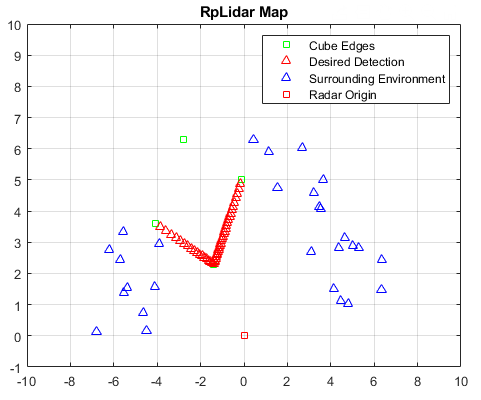

The above shown image is an example of the data generated for the project.

**Data format :**

There are 180 input features. (x0 , x1 , x2 , ..... , x179 )  

Each feature, xi indicating the distance ping from a detected object in the environment and the index, i indicating a corresponding azimuth angle in the scan field (where i = 0 => theta = 0 degrees ; i = 179 => theta = 179 degrees ) .

In the generated synthetic data whenever the desired object is detected on the field scan, the corresponding target yi is updated to be binary 1 and binary 0 elsewhere.

The data was generated in MATLAB and later, exported to a .csv file.

First, the data is imported from the .csv files. The input features are scaled for better results.

In [168]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

X = pd.read_csv("Xtr.csv", sep=',',header=None)
X = X.to_numpy()
X_scal = X/10
#X_scal = X_scal.reshape((X_scal.shape[0],X_scal.shape[1],1))

Y = pd.read_csv("Ytr.csv", sep=',',header=None)
Y = Y.to_numpy()
Y = Y.astype("uint8")

print("Dimensions of input features :",X.shape)
print("Dimensions of output features :",Y.shape)

Dimensions of input features : (10000, 180)
Dimensions of output features : (10000, 180)


In [169]:
from sklearn.model_selection import train_test_split

Xtr, Xts, ytr, yts = train_test_split(X_scal,Y, test_size=0.30)

# Let us first try fitting a simpler neural network model to detect the presence of the desired object given the input features, x . **(In the case of our project, the desired object is a cube)**

In [170]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, BatchNormalization, Dropout, Flatten
import keras.backend as K

num_inputs = 180
num_outputs = 180

K.clear_session()
model = Sequential()
model.add(Dense(units=180, input_shape=(num_inputs,), activation='sigmoid', name='hidden'))
model.add(Dense(units=num_outputs, activation='sigmoid', name='output'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden (Dense)               (None, 180)               32580     
_________________________________________________________________
output (Dense)               (None, 180)               32580     
Total params: 65,160
Trainable params: 65,160
Non-trainable params: 0
_________________________________________________________________


Note : 

There are more number of trainable parameters than the number of available data samples. Hence, Convergence is not guaranteed.

In [171]:
from tensorflow.keras import optimizers

opt = optimizers.Adam(lr=0.001)
model.compile(optimizer=opt,loss='binary_crossentropy')

Fit the designed neural network to the given training data

In [172]:
hist = model.fit(Xtr, ytr, epochs=150, batch_size=100)

Epoch 1/150
70/70 [==============================] - 0s 3ms/step - loss: 0.4505
Epoch 2/150
70/70 [==============================] - 0s 3ms/step - loss: 0.2275
Epoch 3/150
70/70 [==============================] - 0s 3ms/step - loss: 0.1376
Epoch 4/150
70/70 [==============================] - 0s 3ms/step - loss: 0.1116
Epoch 5/150
70/70 [==============================] - 0s 3ms/step - loss: 0.0993
Epoch 6/150
70/70 [==============================] - 0s 3ms/step - loss: 0.0908
Epoch 7/150
70/70 [==============================] - 0s 3ms/step - loss: 0.0840
Epoch 8/150
70/70 [==============================] - 0s 3ms/step - loss: 0.0780
Epoch 9/150
70/70 [==============================] - 0s 3ms/step - loss: 0.0727
Epoch 10/150
70/70 [==============================] - 0s 3ms/step - loss: 0.0681
Epoch 11/150
70/70 [==============================] - 0s 3ms/step - loss: 0.0640
Epoch 12/150
70/70 [==============================] - 0s 3ms/step - loss: 0.0603
Epoch 13/150
70/70 [=================

Plotting the Loss function vs Epochs :

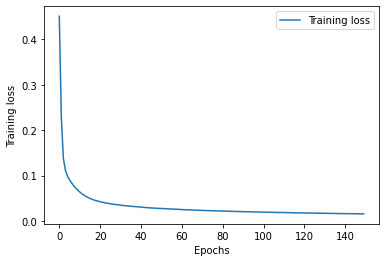

In [173]:
tr_loss = hist.history['loss']
plt.plot(tr_loss)
plt.xlabel('Epochs')
plt.ylabel('Training loss')
plt.legend(['Training loss'])

The loss function is almost about to converge.

In [174]:
y_hat = model.predict(Xts)
y_hat = (y_hat > 0.5)
y_hat = y_hat.astype("uint8")
Simple_NN_Model_Accuracy = np.sum(y_hat == yts)/(yts.shape[0]*yts.shape[1])
print(" Accuracy of the designed simple NN : ",Simple_NN_Model_Accuracy)

 Accuracy of the designed simple NN :  0.9913018518518518


# Let us try using CNN's to check if you could get better results

Adjust the shape of the input parameters before passing it through the CNN

In [175]:
X_scal = X_scal.reshape((X_scal.shape[0],X_scal.shape[1],1))
Xtr, Xts, ytr, yts = train_test_split(X_scal,Y, test_size=0.30)

K.clear_session()

model = Sequential()
model.add(Conv1D( filters = 16 , kernel_size = 9, strides = 3 , padding="valid", activation='relu',input_shape=Xtr.shape[1:]))
model.add(MaxPooling1D( pool_size=3 , strides=1, padding='valid' ))
model.add(BatchNormalization())
model.add(Conv1D( filters = 16 , kernel_size = 9, strides = 3 , padding="valid", activation='relu',input_shape=Xtr.shape[1:]))
model.add(MaxPooling1D( pool_size=3 , strides=1, padding='valid' ))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dropout(0.1))
model.add(Dense(16, activation = 'sigmoid'))
model.add(BatchNormalization())
model.add(Dropout(0.1))
model.add(Dense(num_outputs, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 58, 16)            160       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 56, 16)            0         
_________________________________________________________________
batch_normalization (BatchNo (None, 56, 16)            64        
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 16, 16)            2320      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 14, 16)            0         
_________________________________________________________________
flatten (Flatten)            (None, 224)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 224)               8

Note :

There are reasonably less number of trainable parameters compared to previous NN. Hence, Convergence is possible.

# Fit the designed CNN to the given training data

In [176]:
from tensorflow.keras import optimizers

opt = optimizers.Adam(lr=0.001)
model.compile(optimizer=opt,loss='binary_crossentropy')

hist = model.fit(Xtr, ytr, epochs=150, batch_size=100)

Epoch 1/150
70/70 [==============================] - 1s 11ms/step - loss: 0.6041
Epoch 2/150
70/70 [==============================] - 1s 11ms/step - loss: 0.4581
Epoch 3/150
70/70 [==============================] - 1s 11ms/step - loss: 0.3419
Epoch 4/150
70/70 [==============================] - 1s 11ms/step - loss: 0.2469
Epoch 5/150
70/70 [==============================] - 1s 11ms/step - loss: 0.1849
Epoch 6/150
70/70 [==============================] - 1s 11ms/step - loss: 0.1476
Epoch 7/150
70/70 [==============================] - 1s 11ms/step - loss: 0.1232
Epoch 8/150
70/70 [==============================] - 1s 11ms/step - loss: 0.1081
Epoch 9/150
70/70 [==============================] - 1s 11ms/step - loss: 0.0959
Epoch 10/150
70/70 [==============================] - 1s 11ms/step - loss: 0.0857
Epoch 11/150
70/70 [==============================] - 1s 11ms/step - loss: 0.0799
Epoch 12/150
70/70 [==============================] - 1s 11ms/step - loss: 0.0745
Epoch 13/150
70/70 [=====

Plotting the Loss function vs Epochs :

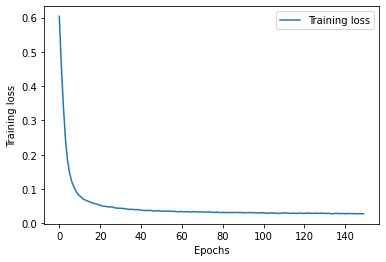

In [177]:
tr_loss = hist.history['loss']
plt.plot(tr_loss)
plt.xlabel('Epochs')
plt.ylabel('Training loss')
plt.legend(['Training loss'])

The loss function seems to converge.

In [178]:
y_hat = model.predict(Xts)
y_hat = (y_hat > 0.5)
y_hat = y_hat.astype("uint8")
CNN_Model_Accuracy = np.sum(y_hat == yts)/(yts.shape[0]*yts.shape[1])
print(" Accuracy of the designed CNN : ",CNN_Model_Accuracy)

 Accuracy of the designed CNN :  0.9963425925925926


We can observe that the accuracy of the CNN is slightly better than that of the simple NN.

# Let us plot a single sample and compare results :

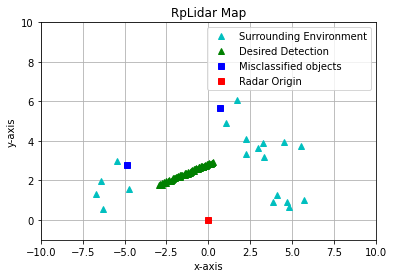

In [268]:
rand_index = np.random.randint(0, high=Xts.shape[0])
X_sample = Xts[rand_index]
Y_sample = yts[rand_index]
y_hat_sample = y_hat[rand_index]

temp_1 = (y_hat_sample & Y_sample) + 2*(y_hat_sample != Y_sample)
x_1 = []
y_1 = []
x_2 = []
y_2 = []
x_3 = []
y_3 = []
for i1 in range(len(temp_1)):
  if X_sample[i1] != 1:
    if temp_1[i1] == 0:
      x_1.append(10*X_sample[i1]*np.cos(2*np.pi*i1/360))
      y_1.append(10*X_sample[i1]*np.sin(2*np.pi*i1/360))
    if temp_1[i1] == 1:
      x_2.append(10*X_sample[i1]*np.cos(2*np.pi*i1/360))
      y_2.append(10*X_sample[i1]*np.sin(2*np.pi*i1/360))
    if temp_1[i1] == 2:
      x_3.append(10*X_sample[i1]*np.cos(2*np.pi*i1/360))
      y_3.append(10*X_sample[i1]*np.sin(2*np.pi*i1/360))

plt.plot(x_1,y_1,"^c",x_2,y_2,"^g",x_3,y_3,"sb",0,0,"sr")
plt.xlim((-10, 10))
plt.ylim((-1, 10))
plt.xlabel('x-axis')
plt.ylabel('y-axis')
plt.title("RpLidar Map")
plt.legend(labels=("Surrounding Environment","Desired Detection","Misclassified objects","Radar Origin"))
plt.grid(True)

# We can observe that the classifier has done a fair job in the identifying the right cube structure in the scan field.

==================================================================================================================

# Finally, Let us focus on the objective of project to predict the boundaries of the desired object in the scan field. 

In [261]:
y_target = np.zeros((y_hat.shape[0],2))
for i1 in range(y_hat.shape[0]):
  Y_sample = y_hat[i1]
  start_i = -1
  max_size = 0
  start_i_temp = -1
  max_size_temp = 0
  counting = False
  for i2 in range(Y_sample.shape[0]):
    if counting and (Y_sample[i2] == 0) :
      counting = False
      if max_size_temp > max_size:
        start_i = start_i_temp
        max_size = max_size_temp
      start_i_temp = -1
      max_size_temp = 0
    if (Y_sample[i2] == 1):
      if (counting == False) :
        counting = True
        start_i_temp = i2
      max_size_temp = max_size_temp + 1
      if ([i2] == Y_sample.shape[0] - 1) and (max_size_temp > max_size):
        start_i = start_i_temp
        max_size = max_size_temp
  y_target[i1,:] = [start_i,start_i+max_size-1]

# Visualizing the outputs y1 and y2 :

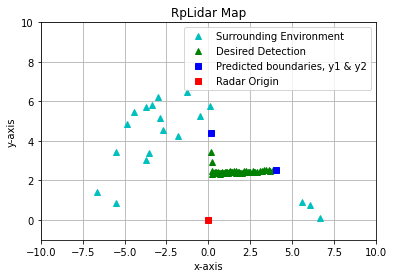

In [262]:
rand_index = np.random.randint(0, high=Xts.shape[0])
X_sample = Xts[rand_index]
y_hat_sample = y_hat[rand_index]
y_hat_sample[int(y_target[rand_index,0])] = 2
y_hat_sample[int(y_target[rand_index,1])] = 2

x_1 = []
y_1 = []
x_2 = []
y_2 = []
x_3 = []
y_3 = []
for i1 in range(len(y_hat_sample)):
  if X_sample[i1] != 1:
    if y_hat_sample[i1] == 0:
      x_1.append(10*X_sample[i1]*np.cos(2*np.pi*i1/360))
      y_1.append(10*X_sample[i1]*np.sin(2*np.pi*i1/360))
    if y_hat_sample[i1] == 1:
      x_2.append(10*X_sample[i1]*np.cos(2*np.pi*i1/360))
      y_2.append(10*X_sample[i1]*np.sin(2*np.pi*i1/360))
    if y_hat_sample[i1] == 2:
      x_3.append(10*X_sample[i1]*np.cos(2*np.pi*i1/360))
      y_3.append(10*X_sample[i1]*np.sin(2*np.pi*i1/360))

plt.plot(x_1,y_1,"^c",x_2,y_2,"^g",x_3,y_3,"sb",0,0,"sr")
plt.xlim((-10, 10))
plt.ylim((-1, 10))
plt.xlabel('x-axis')
plt.ylabel('y-axis')
plt.title("RpLidar Map")
plt.legend(labels=("Surrounding Environment","Desired Detection","Predicted boundaries, y1 & y2","Radar Origin"))
plt.grid(True)

# We can observe that the classifier has identified the boundaries of the desired object right in the scan field.

#**Future Scope :**

# The main idea of this project was to explore the potenial of machine learning to predict the presence of a desired object in the scan field of the LIDAR. If a model could be trained to detect the structure of a cube irrespective of its relative position and orientation, then similarly an equivalent model could be trained to detect any object of a specified structure.

# Given y1 and y2 could be obtained from the input features x, the approx. centriod of the object and the closet point to the object could be determined. These are some of the fundamental problems faced in robot navigation and localization.